In [104]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tarfile
%matplotlib inline

tf.__version__

'2.0.0'

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (InputLayer, ZeroPadding2D, Conv2D, 
                                     Conv2DTranspose, LeakyReLU, BatchNormalization, 
                                     Dense, Flatten, Input, Conv2DTranspose, ReLU)



class Encoder(Model):
    def __init__(self, batch_size, lrelu_slope=0.2):
        super(Model, self).__init__()
        self.initializer = tf.keras.initializers.RandomNormal(stddev=0.02)
        self.inputs = InputLayer(input_shape=(batch_size, 64, 64, 3))
        
        self.pad1 = ZeroPadding2D(padding=(2, 2))
        self.conv1 = Conv2D(filters=128, kernel_size=5, strides=(2, 2), 
                            kernel_initializer=self.initializer)
        
        self.pad2 = ZeroPadding2D(padding=(2, 2))
        self.conv2 = Conv2D(filters=256, kernel_size=5, strides=(2, 2), use_bias=False,
                            kernel_initializer=self.initializer)
        self.bn1 = BatchNormalization()
        self.lrelu2 = LeakyReLU(alpha=lrelu_slope)
        
        self.pad3 = ZeroPadding2D(padding=(2, 2))
        self.conv3 = Conv2D(filters=512, kernel_size=5, strides=(2, 2), use_bias=False,
                            kernel_initializer=self.initializer)
        self.bn2 = BatchNormalization()
        self.lrelu3 = LeakyReLU(alpha=lrelu_slope)
        
        self.pad4 = ZeroPadding2D(padding=(2, 2))
        self.conv4 = Conv2D(filters=1024, kernel_size=5, strides=(2, 2), use_bias=False,
                            kernel_initializer=self.initializer)
        self.bn3 = BatchNormalization()
        self.lrelu4 = LeakyReLU(alpha=lrelu_slope)
        
    def __call__(self, X, training=False):
        network = self.inputs(X)

        network = self.pad1(network)
        network = self.conv1(network)

        network = self.pad2(network)
        network = self.conv2(network) 
        network = self.bn1(network, training=training) 
        network = self.lrelu2(network)

        network = self.pad3(network)
        network = self.conv3(network) 
        network = self.bn2(network, training=training) 
        network = self.lrelu3(network)

        network = self.pad4(network)
        network = self.conv4(network) 
        network = self.bn3(network, training=training)
        
#         network = self.conv5(network)
        return network

class Discriminator(Encoder):
    def __init__(self, batch_size, lrelu_slope=0.2, n_input_channels=3):
        super(Discriminator, self).__init__(batch_size, lrelu_slope)
        if n_input_channels != 3:
            self.inputs = InputLayer(input_shape=(batch_size, 64, 64, n_input_channels))
            
        self.conv = Conv2D(filters=1, kernel_size=4, activation='sigmoid', 
                            kernel_initializer=self.initializer)
    
    @staticmethod
    def loss(logits_real, logits_fake):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return tf.reduce_mean(bce(tf.ones(logits_real.shape), logits_real) + 
                              bce(tf.zeros(logits_fake.shape), logits_fake))
    
    def __call__(self, X, training=False):
        network = super(Discriminator, self).__call__(X)
        network = self.conv(network)
        return network
    
class Decoder(Model):
    def __init__(self, batch_size):
        super(Decoder, self).__init__()
        initializer = tf.keras.initializers.RandomNormal(stddev=0.02)
        self.inputs = InputLayer(input_shape=(batch_size, 2, 2, 64))
        
        self.transp_conv1 = Conv2DTranspose(filters=1024, kernel_size=2, strides=(2, 2),
                                            use_bias=False, kernel_initializer=initializer)
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        
        self.transp_conv2 = Conv2DTranspose(filters=512, kernel_size=2, strides=(2,2), 
                                            use_bias=False, kernel_initializer=initializer)
        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()
        
        self.transp_conv3 = Conv2DTranspose(filters=256, kernel_size=2, strides=(2, 2), 
                                            use_bias=False, kernel_initializer=initializer)
        self.bn3 = BatchNormalization()
        self.relu3 = ReLU()
        
        self.transp_conv4 = Conv2DTranspose(filters=128, kernel_size=2, strides=(2, 2), 
                                            use_bias=False, kernel_initializer=initializer)
        self.bn4 = BatchNormalization()
        self.relu4 = ReLU()
        
        self.transp_conv5 = Conv2DTranspose(filters=3, kernel_size=2, strides=(2, 2), activation='tanh', 
                                            use_bias=False, kernel_initializer=initializer)
        
    def __call__(self, X, training=False):
        network = self.inputs(X)
#         print(network.shape)
        network = self.transp_conv1(network)
        network = self.bn1(network, training=training)
        network = self.relu1(network)
#         print(network.shape)
        network = self.transp_conv2(network)
        network = self.bn2(network, training=training)
        network = self.relu2(network)
#         print(network.shape)
        network = self.transp_conv3(network)
        network = self.bn3(network, training=training)
        network = self.relu3(network)
#         print(network.shape)
        network = self.transp_conv4(network)
        network = self.bn4(network, training=training)
        network = self.relu4(network)
#         print(network.shape)
        network = self.transp_conv5(network)
#         print(network.shape)
        return network
        
class Converter:
    def __init__(self, batch_size):
        initializer = tf.keras.initializers.RandomNormal(stddev=0.02)
        self.inputs = InputLayer(input_shape=(batch_size, 64, 64, 3))
        self.encoder = Encoder(batch_size)
        self.conv = Conv2D(filters=64, kernel_size=3, kernel_initializer=initializer)
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.decoder = Decoder(batch_size)
        
    def __call__(self, X, training=False):
        network = self.inputs(X)
        network = self.encoder(network)
        
        network = self.conv(network)
        network = self.bn(network)
        network = self.relu(network)

        network = self.decoder(network)
        return network

In [3]:
def test_converter():
    batch_size = 1
    conv = Converter(batch_size)
    X = tf.zeros((batch_size, 64, 64, 3))
    y = conv(X)
    assert y.shape == (batch_size, 64, 64, 3)
    print('Encoder produces output of valid shape.')
    
def test_discriminator():
    batch_size = 128
    X = tf.zeros((batch_size, 64, 64, 3))
    real_fake_discrim = Discriminator(batch_size)
    y = real_fake_discrim(X)
    assert y.shape == (batch_size, 1, 1, 1)
    
    domain_discrim = Discriminator(batch_size, n_input_channels=6)
    X = tf.zeros((batch_size, 64, 64, 6))
    y = domain_discrim(X)
    assert y.shape == (batch_size, 1, 1, 1)
    print('Discriminator produces outputs of valid shape.')

test_converter()
test_discriminator()

Encoder produces output of valid shape.
Discriminator produces outputs of valid shape.


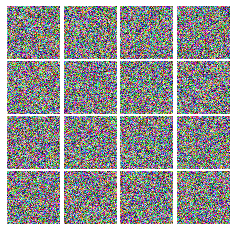

In [4]:
def sample_noise(shape):
    return tf.random.uniform(shape, minval=-1.0, maxval=1.0)

def show_images(images, scaled=True):
    if scaled:
        images = (images * 255).astype(np.uint8)

    img_size = images.shape[1]
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([img_size, img_size, 3]))

im = sample_noise((16, 64, 64, 3)).numpy()
show_images(im)

In [76]:
import glob
import os


def train_test_split(data, test_size=0.05):
    size = len(data)
    n_test = int(size * test_size)

    train, test = (data[:-n_test], data[-n_test:])
    return train, test

def get_photo_id(file_name):
        return file_name.split('_')[0]

def group_data(names):
    '''
        Create array of items where each item contains several image paths from the
        source domain and one from the target domain.
    '''
    data = []
    curr_heap = []
    curr_photo_id = get_photo_id(names[0])
    for file_name in names:
        photo_id = get_photo_id(file_name)
        if photo_id != curr_photo_id:
            data.append((curr_heap[:-1], curr_heap[-1]))
            curr_photo_id = photo_id
            curr_heap.clear()
            
        curr_heap.append(file_name)

    return data

def make_square(img, size=64, fill_color=(255, 255, 255)):
    img.thumbnail((size, size))
    width, height = img.size
    new_img = Image.new('RGB', (size, size), fill_color)
    new_img.paste(img, (int((size - width) / 2), int((size - height) / 2)))
    return new_img
    
def preprocess_images(img_paths, img_size, save_fp):
    '''
        Rescale all images to have img_size pixels at a longer side while keeping the aspect ratio, 
        and fill the margins of both ends with 255s
    '''
    for source, target in img_paths:
        example = list(source)
        example.append(target)
        for path in example:                
            try:
                img = make_square(Image.open(path), img_size)
                _, tail = os.path.split(path)
                img.save(os.path.join(save_fp, tail), "JPEG")
            except Exception as e:
                print(f'Could not preprocess {path}. {e}')

def load_dataset(raw_fp, train_fp, val_fp, test_fp):
    names = sorted(glob.glob(os.path.join(raw_fp, '*.jpg')))
    data = group_data(names)

    train, val_test = train_test_split(data, 0.1)
    val, test = train_test_split(val_test, 0.5)

    preprocess_images(train, 64, train_fp)
    print('Train data is loaded.')
    preprocess_images(val, 64, val_fp)
    print('Validation data is loaded.')
    preprocess_images(test, 64, test_fp)
    print('Test data is loaded.')

In [93]:
IMAGE_FOLDER = './data/images/'
RAW_FOLDER = os.path.join(IMAGE_FOLDER, 'raw')
TRAIN_FOLDER = os.path.join(IMAGE_FOLDER, 'train')
VAL_FOLDER = os.path.join(IMAGE_FOLDER, 'val')
TEST_FOLDER = os.path.join(IMAGE_FOLDER, 'test')

# load_dataset(RAW_FOLDER, TRAIN_FOLDER, VAL_FOLDER, TEST_FOLDER)

In [91]:
class Dataset:
    def __init__(self, train_fp, val_fp, test_fp):
        self._train_fp = train_fp
        self._val_fp = val_fp
        self._test_fp = test_fp
                
    def get_iter(self, batch_size, data='test'):
        folder_fp = (self._train_fp if data == 'train' 
                     else self._val_fp if data == 'val' 
                     else self._test_fp)
        
        names = sorted(glob.glob(os.path.join(self._train_fp, '*.jpg')))
        grouped_names = group_data(names)
        X = []
        for source, domain in grouped_names:
            X.extend(list(zip(source, [domain]*len(source))))

        N = len(names)
        for i in range(0, N, batch_size):
            yield np.array([(np.asarray(Image.open(p1)), 
                    np.asarray(Image.open(p2))) for p1, p2 in X[i:i+batch_size]])
                
lookbook = Dataset(TRAIN_FOLDER, VAL_FOLDER, TEST_FOLDER)
it = lookbook.get_iter(32, 'train')
b = next(it)

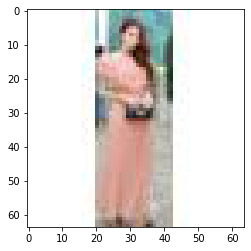

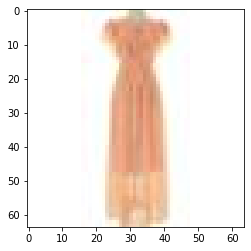

In [107]:
i1, i2 = b[1]
plt.figure()
plt.imshow(i1.astype(np.uint8))
plt.figure()
plt.imshow(i2)
plt.show()


In [6]:
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
MOMENTUM = 0.5
n_epochs = 25
device = '/device:GPU:0'

solver = tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)
real_fake_discrim = Discriminator(BATCH_SIZE)
domain_discrim = Discriminator(BATCH_SIZE, n_input_channels=6)


for i in range(n_epochs):
    for

converter = Converter(BATCH_SIZE)


SyntaxError: invalid syntax (<ipython-input-6-7f862bf2c243>, line 13)